In [1]:
#@title Imports external sources
import os
import io
import PIL.Image, PIL.ImageDraw, PIL.ImageFont
import base64
import zipfile
import json
import requests
import matplotlib.pylab as pl
import numpy as np
import glob
import requests
import random as pyrandom
from concurrent import futures
from functools import partial
from scipy.ndimage import rotate
from IPython.display import Image, HTML, clear_output
from tqdm import tqdm_notebook, tnrange
import time
from typing import Any, MutableMapping, NamedTuple, Tuple
# !pip install --quiet --upgrade tensorflow 
# !pip install --quiet --upgrade jax
# !pip install --quiet --upgrade jaxlib
import jax
from jax import grad, jit, vmap
import jax.numpy as jnp

# !pip install --quiet -U dm-haiku
# !pip install --quiet -U optax
import haiku as hk
import math
# !pip install --quiet -U ml_collections
from ml_collections import config_dict
import matplotlib.pylab as pl
import matplotlib.colors as mcolors
colors = pl.colormaps['Dark2'] 

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
#@title Import internal sources (from github)
# !git clone --quiet https://github.com/google-research/self-organising-systems.git /content/self-organising-systems > /dev/null 2>&1
# %cd /content/self-organising-systems/transformers_learn_icl_by_gd
from src.transformer import Transformer
from src.data import create_circ_cls_data, create_weights
from src.config import config
from src.train import *

2024-05-19 01:58:03.477384: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.99). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
from torchvision.datasets import MNIST
import numpy as np
import jax.numpy as jnp
from jax.tree_util import tree_map
from torch.utils import data
from torchvision.datasets import MNIST

def concate_feature_label_collate(batch):
  features, labels = zip(*batch)
  # append labels to the features
  concatenated = [np.concatenate([f, np.array([l])]) for f, l in zip(features, labels)]
  return np.array(concatenated, dtype=jnp.float32)

def numpy_collate(batch):
  return tree_map(np.asarray, concate_feature_label_collate(batch))

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

# Define our dataset, using torch datasets
mnist_dataset = MNIST('./data', train=True, download=True, transform=FlattenAndCast())
training_generator = NumpyLoader(mnist_dataset, batch_size=1, num_workers=0)
# convert to a np array
mnist_data = np.array(list(training_generator))

# squeeze the 2nd dimension
mnist_data = np.squeeze(mnist_data, axis=1)

# filter out all entries in mnist_data with last element other than [0,1,2]
num_classes = 2
total_classes = 5
assert total_classes >= num_classes
filtered_mnist_data = mnist_data[mnist_data[..., -1] < num_classes]

# batch the data
bs = 10
num = filtered_mnist_data.shape[0] // bs * bs
batched_mnist_data = np.asarray(np.split(filtered_mnist_data[:num], bs))
batched_mnist_data = batched_mnist_data.transpose(1, 0, 2)

In [4]:
# augment each batch in batched_mnist_data with different label mapping
augmented_batched_mnist_data = []
for i, batch in enumerate(batched_mnist_data):
  augmented_batch = np.copy(batch)
  for _ in range(4):
    # random permutation of total_classes
    perm = np.random.permutation(total_classes)
    augmented_batch[..., -1] = perm[augmented_batch[..., -1].astype(int)]
    augmented_batched_mnist_data.append(np.copy(augmented_batch))

In [5]:
augmented_batched_mnist_data = jnp.array(augmented_batched_mnist_data)
# randomly shuffle the data with numpy
augmented_batched_mnist_data = augmented_batched_mnist_data[np.random.permutation(augmented_batched_mnist_data.shape[0])]
batched_mnist_data = augmented_batched_mnist_data

In [6]:
# split batched_mnist_data into train and test set, 0.8/0.2
split = np.split(batched_mnist_data, [int(0.8 * batched_mnist_data.shape[0])])
train_set = split[0]
test_set = split[1]

In [7]:
train_set.shape, test_set.shape

((4051, 10, 785), (1013, 10, 785))

In [8]:
train_set = jnp.array(train_set)
train_mnist_data = train_set.at[:, -1, -1].set(-1) # -1 for null label
train_mnist_y = train_set[:, -1]

test_set = jnp.array(test_set)
test_mnist_data = test_set.at[:, -1, -1].set(-1) # -1 for null label
test_mnist_y = test_set[:, -1]

# pack into train_data and eval_data
train_data = (train_mnist_data, train_mnist_y)
eval_data = (test_mnist_data, test_mnist_y)

In [9]:
eval_data[0].shape, eval_data[1].shape

((1013, 10, 785), (1013, 785))

In [10]:
#@title Config
num_seeds = 1 #@param {type:"integer"}

from datetime import datetime
now = datetime.now()
config.local_usage = True
config.size_distract = 0
config.training_steps = 5000
config.training_steps_gd = 5000
config.use_softmax = True
config.mnist_task = True

####
config.deq = True
config.gd_deq = True
####
config.pre_train_gd = False
config.train_gd_whitening = False
config.train_gd_lr = True
####

config.layer_norm = True
config.out_proj = True
config.in_proj = False
config.adam = True

config.output_size = total_classes

config.dataset_size = 9
config.input_size = 39
config.key_size = 40 #config.input_size + 1
config.num_layers = 10
config.num_heads = 20
config.grad_clip_value = 100
config.grad_clip_value_gd = 100
config.lr = 0.001
config.wd = 0.0
config.init_scale = 0.002 / config.num_layers
config.bs = 2048
config.bs_gd_train = 2048
config.gd_lr = 0.0003

config.dropout_rate = 0.0
data_creator = vmap(create_circ_cls_data,
                    in_axes=(0, None, None, None, None, None),
                    out_axes=0)

config.y_update = False
config.input_range = 2.0
config.seed = 0

config.analyse = False
config.input_mlp = True
config.input_mlp_out_dim = 120
config.widening_factor = 4
config.sum_norm = False


config.in_proj = True
config.emb_size = 120
config.num_seeds = num_seeds

change_dataloader()

In [11]:
#@title Lists
loss_trans_list =  [[]  for _ in range(config.num_seeds)]

In [12]:
from utils import load_weights

In [13]:
#@title Training
eval_rng = jax.random.PRNGKey(10)
for cur_seed in range(config.num_seeds):
  if cur_seed == 1:
    save_train_params = train_state.params
  config.seed = cur_seed  
  optimiser, train_state, _, rng = init(train_data)
  save_train_params = load_weights(train_state.params, "data/mnist_pretrained.pkl")
  break
  # rng, data_rng = jax.random.split(rng, 2)
  # eval_data = data_creator(jax.random.split(eval_rng, num=config.bs),
  #                              config.input_size,
  #                              config.dataset_size,
  #                              config.size_distract,
  #                              config.input_range,
  #                              config.weight_scale)
  
  for step in range(config.training_steps):
    # rng, data_rng = jax.random.split(data_rng, 2)
    # train_data = data_creator(jax.random.split(rng, num=config.bs), 
    #                           config.input_size,
    #                           config.dataset_size,
    #                           config.size_distract,
    #                           config.input_range,
    #                           config.weight_scale)
    train_state, metrics = update(train_state, train_data, optimiser)
    
    #for params in train_state.params:
    #  if "mlp" in params or 'emb' in params:
    #    train_state.params[params] = params_c[params.replace("transformer", "Transformer_gd")]
    if step % 1000 == 0:
      
      loss_trans, _, _ = predict_test.apply(train_state.params, eval_rng,
                                            eval_data, False)
      
      loss_trans_list[cur_seed].append(loss_trans)

# if config.num_seeds == 1:
#   save_train_params = train_state.params
#   # plot loss_trans_list
#   pl.plot(loss_trans_list[0])

In [14]:
def get_embedding(data):
    # emb = save_train_params['transformer/emb']['w']
    # l0 = save_train_params['transformer/input_mlp/linear']['w']
    # l1 = save_train_params['transformer/input_mlp/linear_1']['w']

    # embedded = jnp.einsum('ba,dcb->dca', emb, data)

    # embedded = embedded + jnp.einsum('aa,cba->cba', l1.T @ l0.T, embedded)
    # return embedded
    return predict_stack.apply(save_train_params, eval_rng, data, False)

In [167]:
tr_idx = 5
X = eval_data[0]
Y = eval_data[1]

# perturb X
# perturb_num = 2
# X = X.at[tr_idx, :perturb_num, 2].add(10.0)
X_only = X.at[:, :, -1].set(-1)

emb = get_embedding(X_only)[tr_idx]
# standardize
# emb = (emb - emb.mean(axis=0)) / emb.std(axis=0)
gt = X[tr_idx][:, -1]
# w = jnp.linalg.lstsq(emb[:-1], gt[:-1])[0]
# w = train_weight(emb[:-1], gt[:-1], lr=0.01)

X_b = emb[:-1]
n_features = X_b.shape[1]
y = gt[:-1]
alpha = 0.01

# convert y to one hot
y = jax.nn.one_hot(y, config.output_size)

w = np.linalg.inv(X_b.T.dot(X_b) + alpha * np.eye(n_features)).dot(X_b.T).dot(y)


In [168]:
def calc_influence(idx):
    # the first 10 are inputs, the last one is test
    emb_train_all = emb[:-1]
    emb_train = emb[idx:idx+1]
    emb_test = emb[-1:]

    gt_train = X[tr_idx][idx:idx+1, -1]
    gt_test = Y[tr_idx][-1]

    k = emb_train_all.T @ emb_train_all
    # influence of the training data on w
    pred = emb_train @ w
    gt_train_one_hot = jax.nn.one_hot(gt_train, config.output_size)
    infl_w = np.linalg.solve(k + alpha * jnp.eye(k.shape[0]), emb_train.T @ (pred - gt_train_one_hot) + alpha * w)
    # influence of a test point on w
    gt_test_one_hot = jax.nn.one_hot(gt_test, config.output_size)
    d_loss = emb_test.T @ (emb_test @ w - gt_test_one_hot) + alpha * w
    return (jnp.ravel(d_loss) @ jnp.ravel(infl_w)).item()


In [169]:
infls = []
for i in range(config.dataset_size):
    infl = calc_influence(i)
    infls.append(infl)
infls = jnp.array(infls)
# normalize the influence
infls = infls / jnp.linalg.norm(infls)
for i in range(config.dataset_size):
    print(f"index {i}, normalized influence: {infls[i]}")

index 0, normalized influence: -0.3304947316646576
index 1, normalized influence: -0.31288060545921326
index 2, normalized influence: -0.39792436361312866
index 3, normalized influence: -0.32680097222328186
index 4, normalized influence: -0.28126442432403564
index 5, normalized influence: -0.31559836864471436
index 6, normalized influence: -0.3455107510089874
index 7, normalized influence: -0.306253582239151
index 8, normalized influence: -0.3685857951641083


[0 2 6 8 9]
[-27.83828  -22.616919 -10.740705  -3.082974  -7.418506]
[1 3 4 5 7 9]
[-40.977932  -21.96825    -5.102263   -3.972045   -0.5478198]


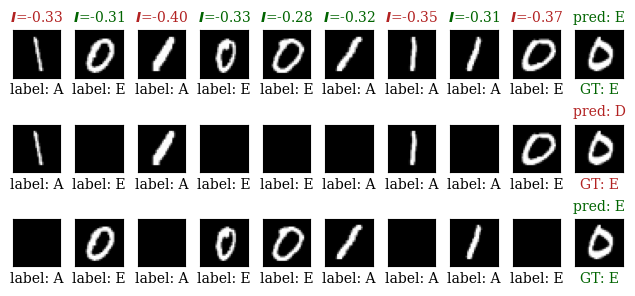

In [170]:
from utils import set_up_plotting

set_up_plotting()

image_arrays = X[tr_idx][:-1, :-1].reshape(-1, 28, 28)
labels = X[tr_idx][:-1, -1]

map_int_to_abcd = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E'}

# plot all the images in the dataset
for i, image in enumerate(image_arrays):
    ax = pl.subplot(3, 10, i+1)
    ax.imshow(image, cmap='gray')
    # highlight images with high influence
    # find the median of the influence
    median = jnp.median(infls)
    if infls[i] >= median:
        ax.set_title(rf"$I$={infls[i]:.2f}", color='darkgreen', fontsize=10)
    else:
        ax.set_title(rf"$I$={infls[i]:.2f}", color='firebrick', fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(f"label: {map_int_to_abcd[int(labels[i])]}", fontsize=10)

test_image = X[tr_idx][-1, :-1].reshape(28, 28)
label = Y[tr_idx][-1]
pred_trans = predict.apply(save_train_params, eval_rng, X[tr_idx:tr_idx+1], False)
# pred_trans = pred_trans[:, -1, -1]*(-1.0)
pred_trans = jnp.argmax(pred_trans[:, -1])


ax = pl.subplot(3,10,10)
ax.imshow(test_image, cmap='gray')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(f"pred: {map_int_to_abcd[int(pred_trans)]}", color='darkgreen', fontsize=10)
ax.set_xlabel(f"GT: {map_int_to_abcd[int(label)]}", color='darkgreen', fontsize=10)



"""Remove the top 5 images with the highest influence
"""

image_arrays = X[tr_idx][:-1, :-1].reshape(-1, 28, 28)
labels = X[tr_idx][:-1, -1]

test_image = X[tr_idx][-1, :-1].reshape(28, 28)
label = Y[tr_idx][-1]
num_remove = 5
ranks = jnp.argsort(infls)[:-num_remove]
# sort the indices in descending order
ranks = ranks.sort()
# append the test image idx to ranks
ranks = jnp.append(ranks, config.dataset_size)
print(ranks)

# plot all the remaining images in the dataset
for i, image in enumerate(image_arrays):
    if i not in ranks:
        image = np.ones_like(image) * 255
    ax = pl.subplot(3, 10, 10 + i+1)
    ax.imshow(image, cmap='gray')
    # highlight images with high influence
    # median = jnp.median(infls)
    # if infls[i] >= median:
    #     ax.set_title(rf"$I$={infls[i]:.2f}", color='darkgreen', fontsize=10)
    # else:
    #     ax.set_title(rf"$I$={infls[i]:.2f}", color='firebrick', fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(f"label: {map_int_to_abcd[int(labels[i])]}", fontsize=10)

logits = predict.apply(save_train_params, eval_rng, X[tr_idx:tr_idx+1, ranks], False)[-1, -1]
print(logits)
pred_trans = jnp.argmax(logits)


ax = pl.subplot(3,10,20)
ax.imshow(test_image, cmap='gray')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(f"pred: {map_int_to_abcd[pred_trans.item()]}", color='firebrick', fontsize=10)
ax.set_xlabel(f"GT: {map_int_to_abcd[int(label)]}", color='firebrick', fontsize=10)





"""Remove the bottom 5 images with the lowest influence
"""


image_arrays = X[tr_idx][:-1, :-1].reshape(-1, 28, 28)
labels = X[tr_idx][:-1, -1]

test_image = X[tr_idx][-1, :-1].reshape(28, 28)
label = Y[tr_idx][-1]
num_remove = 5
ranks = jnp.argsort(infls)[num_remove-1:]
# sort the indices in descending order
ranks = ranks.sort()
ranks = jnp.append(ranks, config.dataset_size)
print(ranks)

# plot all the remaining images in the dataset
for i, image in enumerate(image_arrays):
    ax = pl.subplot(3, 10, 20 + i+1)
    if i not in ranks:
        # show the removed images in white
        image = np.ones_like(image) * 255
    ax.imshow(image, cmap='gray')
    # highlight images with high influence
    # median = jnp.median(infls)
    # if infls[i] >= median:
    #     ax.set_title(rf"$I$={infls[i]:.2f}", color='darkgreen', fontsize=10)
    # else:
    #     ax.set_title(rf"$I$={infls[i]:.2f}", color='firebrick', fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(f"label: {map_int_to_abcd[int(labels[i])]}", fontsize=10)

logits = predict.apply(save_train_params, eval_rng, X[tr_idx:tr_idx+1, ranks], False)[-1, -1]
print(logits)
pred_trans = jnp.argmax(logits)


ax = pl.subplot(3,10,30)

ax.imshow(test_image, cmap='gray')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(f"pred: {map_int_to_abcd[ pred_trans.item() ]}", color='darkgreen', fontsize=10)
ax.set_xlabel(f"GT: {map_int_to_abcd[ int(label) ]}", color='darkgreen', fontsize=10)







# make the plot look nice
pl.tight_layout(h_pad=-10)

# save the plot
pl.savefig(f"figs/influence_mnist_all_data.pdf", format='pdf', bbox_inches='tight', dpi=300)

# pl.show()